# Human in the Loop (HITL) Quality Control Assessments

The OOI M2M API includes a database of "human in the loop" (HITL) quality control (QC) assessments of the data. Users can fairly easily access this data and use the QC flags to see what annotations exist for the data set of interest, remove data that has been marked as failed or suspect from their analysis, or see why there might be gaps or missing data.

In [1]:
import datetime
import os
import pandas as pd
import requests
import xarray as xr

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

from ooi_data_explorations.common import get_annotations

import warnings
warnings.filterwarnings('ignore')

Loading the annotations is as simple as a single call to the M2M system listing the site, node and sensor designators. From there converting the annotations into a pandas Dataframe and converting the time into useful datetime objects is straight forward. 

In [2]:
# continue using the Washington Inshore surface mooring for the example
site = 'CE06ISSM'
node = 'RID16'
sensor = '03-DOSTAD000'

# use the M2M api to request the annotations specific to this sensor. 
# the returned data is a JSON formatted dictionary.
r = get_annotations(site, node, sensor)

# convert the JSON structure to a pandas dataframe
annos = pd.DataFrame.from_dict(r)

# convert the beginning and end times to datetime objects
annos['beginDT'] = pd.to_datetime(annos.beginDT, unit='ms')
annos['endDT'] = pd.to_datetime(annos.endDT, unit='ms')

# set the index to the annotation ID and sort by the ID
annos.index = annos['id']
annos = annos.sort_index()

Each annotation includes a `qcFlag` variable. These are strings which can be easily mapped to their [QARTOD](https://ioos.noaa.gov/project/qartod/) equivalents. If the `qcFlag` variable is not set, the annotation is a note that may provide further information

In [3]:
# Reset the QC flags to categories equivalent to the QARTOD codes, using Pass = 1, 
# Not Evaluated = 2, Suspect or of High Interest = 3, Fail = 4, and Missing Data = 9
# QC flags set to 0 represent operational notes. These are not necessarily QC flags,
# but may provide information about the instrument that can be used for further QC
# assessments.
codes = {None: 0, 'pass': 1, 'not_evaluated': 2, 'suspect': 3, 'fail': 4, 'not_operational': 9, 'not_available': 9, 'pending_ingest': 9}
annos['qcFlag'] = annos['qcFlag'].map(codes).astype('category')

In [4]:
# Load the NSIF DO data from CE06ISSM for all of Deployment 11 (October 2019 - July 2020)
home = os.path.expanduser('~')
m2m_base = os.path.abspath(os.path.join(home, 'ooidata/m2m'))
data_path = os.path.join(m2m_base, 'ce06issm', 'nsif', 'dosta')
# Note, the data file used below was downloaded earlier as part of a larger effort
# to assess the quality of the dissolved oygen data.
ce06 = xr.load_dataset(os.path.join(data_path, 'ce06issm.nsif.dosta.deploy11.recovered_inst.dosta_abcdjm_ctdbp_instrument_recovered.nc'))

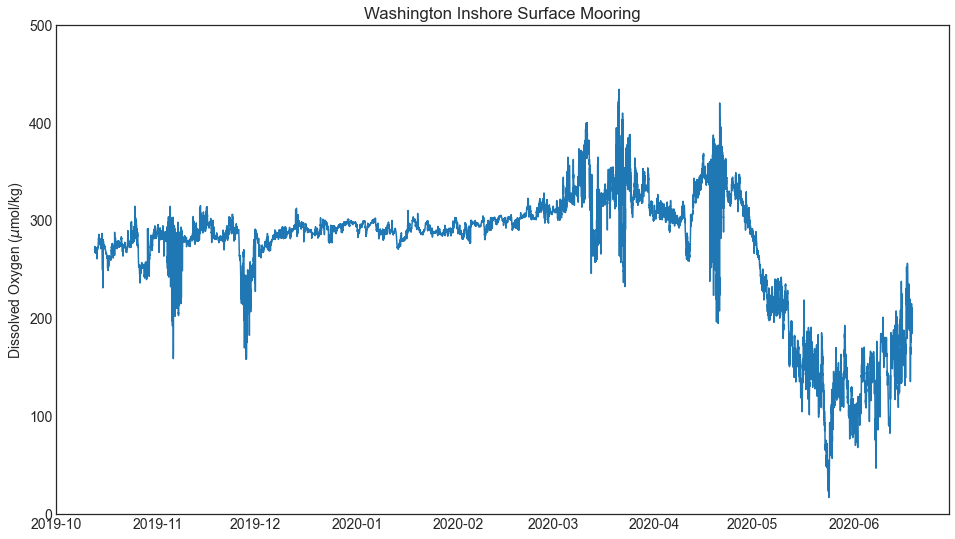

In [5]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.plot(ce06.time, ce06.oxygen_concentration_corrected[0, :], '-', label='7 m')
plt.title('Washington Inshore Surface Mooring')
plt.ylabel(r'Dissolved Oxygen ($\mu$mol/kg)')
plt.xlim(datetime.date(2019, 10, 1), datetime.date(2020, 6, 30))
plt.ylim(0, 500)
plt.show()

The data plotted above shows the dissolved oxygen data collected on the Washington Inshore surface mooring at 7 m. At first glance it looks reasonable. However, I know that when the mooring was recovered in July, the DO sensor was heavily biofouled. The likelihood is that the data collected at the end of the deployment is not correct, and instead represents respiration by all the encrusting critters growing on the platform. I was able to use data from other sensors to determine when that biofouling likely started to dominate the signal and create an annotation. The plot below uses that annotation to highlight the data that is likely to be suspect. 

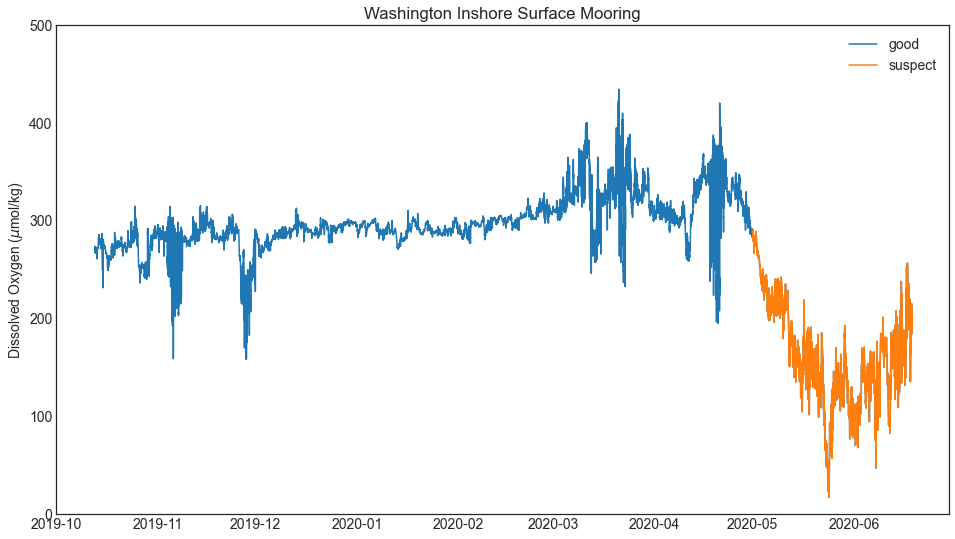

In [6]:
# find the suspect annotations and use the beginning date to color the suspect data points
suspect = annos.loc[(annos['qcFlag'] == 3) & (annos['beginDT'] >= ce06['time'].values[0])]
m = ce06['time'] >= suspect['beginDT'].values

plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.plot(ce06.time, ce06.oxygen_concentration_corrected[0, :], '-', label='good')
plt.plot(ce06.time[m], ce06.oxygen_concentration_corrected[0, m], '-', label='suspect')
plt.title('Washington Inshore Surface Mooring')
plt.ylabel(r'Dissolved Oxygen ($\mu$mol/kg)')
plt.xlim(datetime.date(2019, 10, 1), datetime.date(2020, 6, 30))
plt.ylim(0, 500)
plt.legend()
plt.show()

In [7]:
suspect['annotation'].values[0]

'The batteries which power the UV Biofouling control system were found drained upon mooring recovery, and the sensor face of the DOSTA was biofouled. We do not know exactly when biofouling started, but data after the 1st of May (mooring was recovered and replaced on July 14th) appears to suggest biofouling may have come to dominate the signal. The data collected after May 1st are marked as suspect.'